# Setup

In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
options(warn = -1)
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



# Exploration

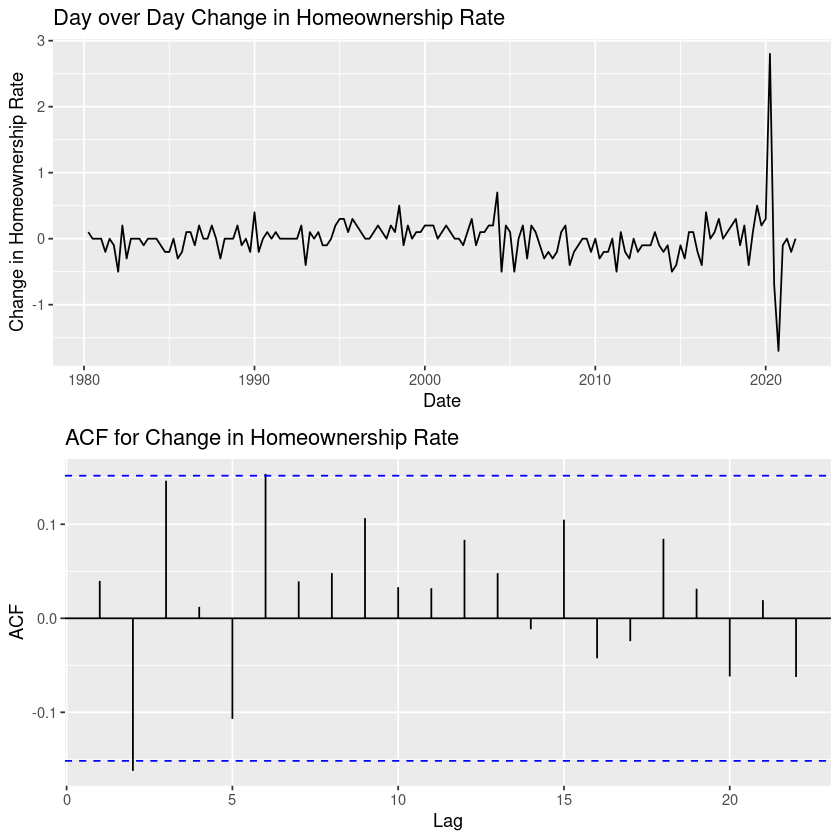

In [2]:
homeownership <- read_homeownership()
homeownership_diff <- homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

# Cleaning Outliers

In [3]:
outliers <- tsoutliers(homeownership$Value)
outliers
cleaned_homeownership <- homeownership
cleaned_homeownership$Value[outliers$index] <- outliers$replacements

$index
[1] 162 163

$replacements
[1] 65.43333 65.56667

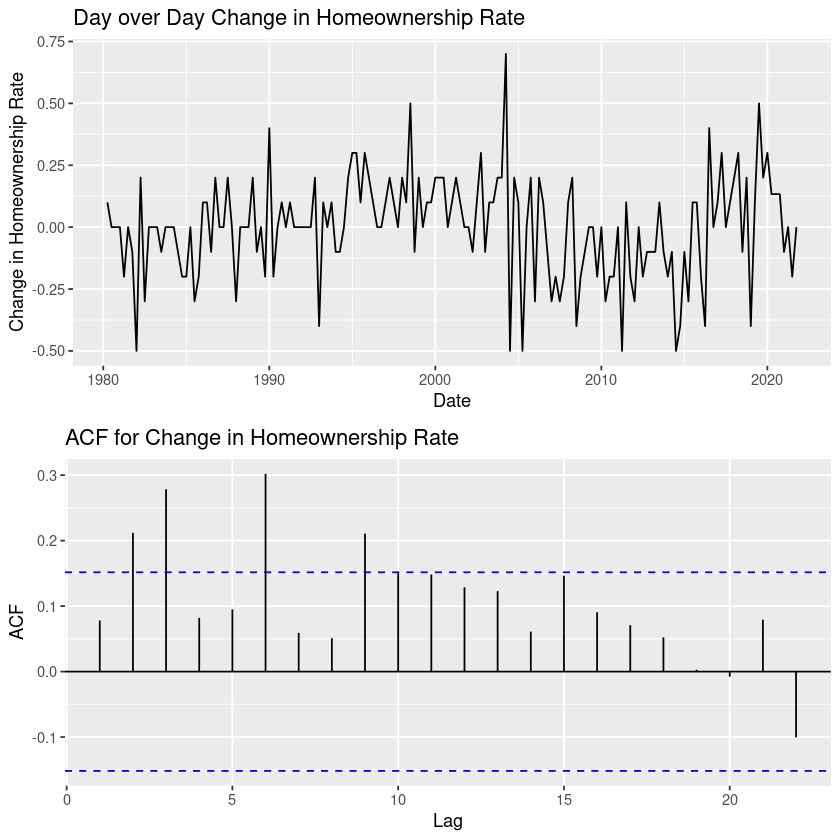

In [4]:
homeownership_diff <- cleaned_homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

# ARIMA Fit

In [5]:
test_split = 4
train <- head(homeownership_diff, -test_split)
test <- tail(homeownership_diff, test_split)
arima_comp <- find_best_arima(train$dValue, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,5,0,4,-74.22452
2,4,0,5,-74.21591
3,5,0,5,-71.75588
4,3,0,3,-71.75546
5,2,1,3,-70.07758
6,3,0,4,-69.52296



	Box-Ljung test

data:  residuals(model)
X-squared = 2.5973, df = 1, p-value = 0.107


	Box-Ljung test

data:  residuals(model)^2
X-squared = 9.936, df = 1, p-value = 0.001621



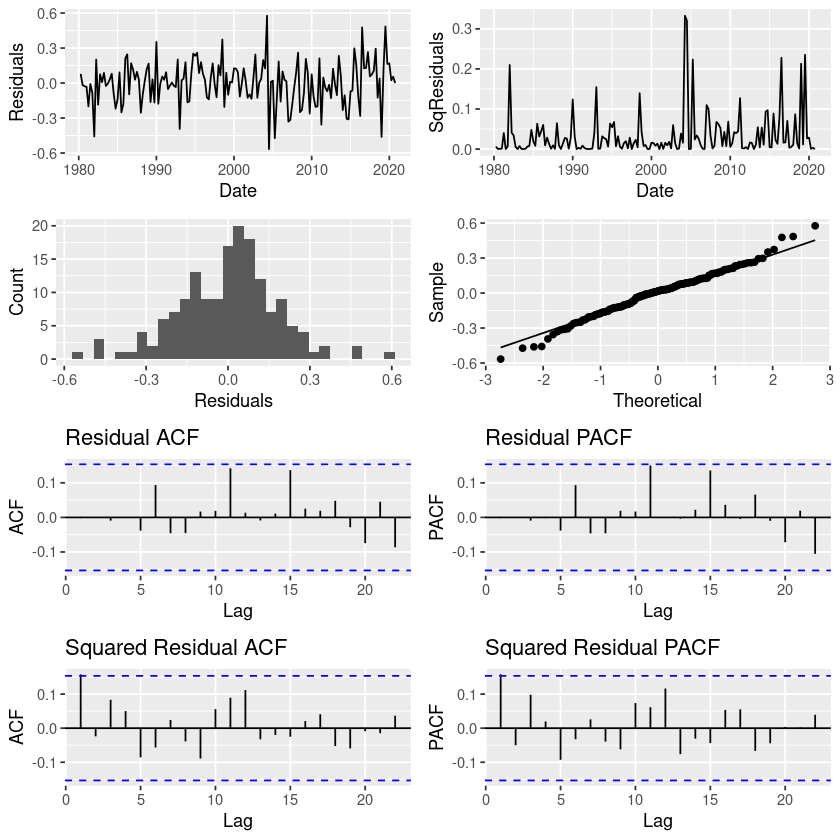

In [6]:
best_order <- arima_comp[1,1:3] %>% as.numeric
arima_model <- arima(train$dValue, order = best_order, method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# ARMA-GARCH Fit

In [7]:
ugarch_comp <- find_best_ugarch(homeownership_diff$dValue, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,5,3,0,1,-0.4227619
2,5,3,2,1,-0.3432862
3,5,3,2,0,-0.2978037
4,5,3,1,0,-0.2462543
5,5,3,0,0,-0.2133050
6,5,3,0,2,-0.1698879


## Model 1: Best Orders


	Box-Ljung test

data:  residuals(model)
X-squared = 15.36, df = 1, p-value = 8.883e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 6.6237, df = 1, p-value = 0.01006



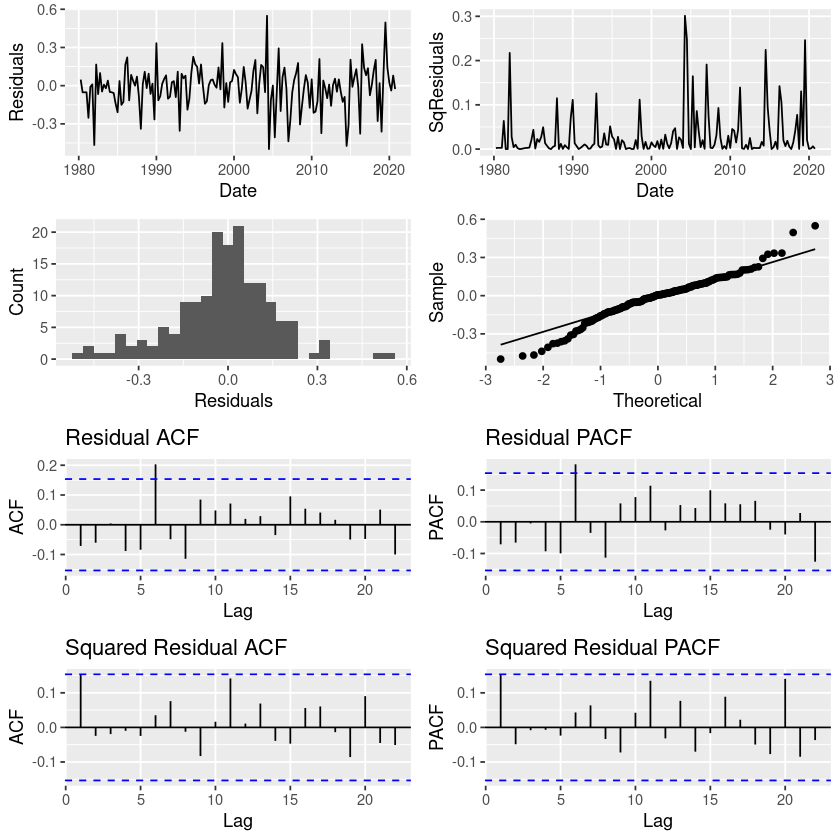

In [8]:
best_order <- as.numeric(ugarch_comp$Final[1,1:4])
spec1 <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model1 <- ugarchfit(spec1, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, sum(best_order))

## Model 2: Forced GARCH(1,1)


	Box-Ljung test

data:  residuals(model)
X-squared = 7.8143, df = 1, p-value = 0.005184


	Box-Ljung test

data:  residuals(model)^2
X-squared = 12.082, df = 1, p-value = 0.000509



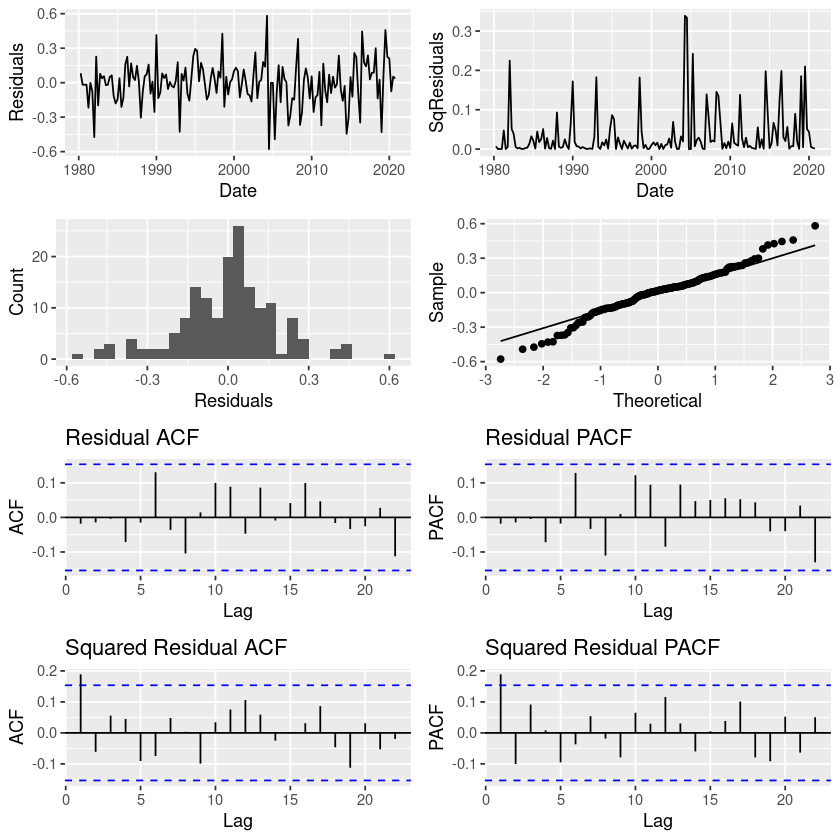

In [9]:
spec2 <- ugarchspec(variance.model=list(garchOrder=c(1,1)),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model2 <- ugarchfit(spec2, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model2, train$Date)
box_tests(ugarch_model2, sum(best_order))

# Forecasting

## ARIMA

PM =  5.916148

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1828552,0.2016768,0.1828552,-Inf,Inf


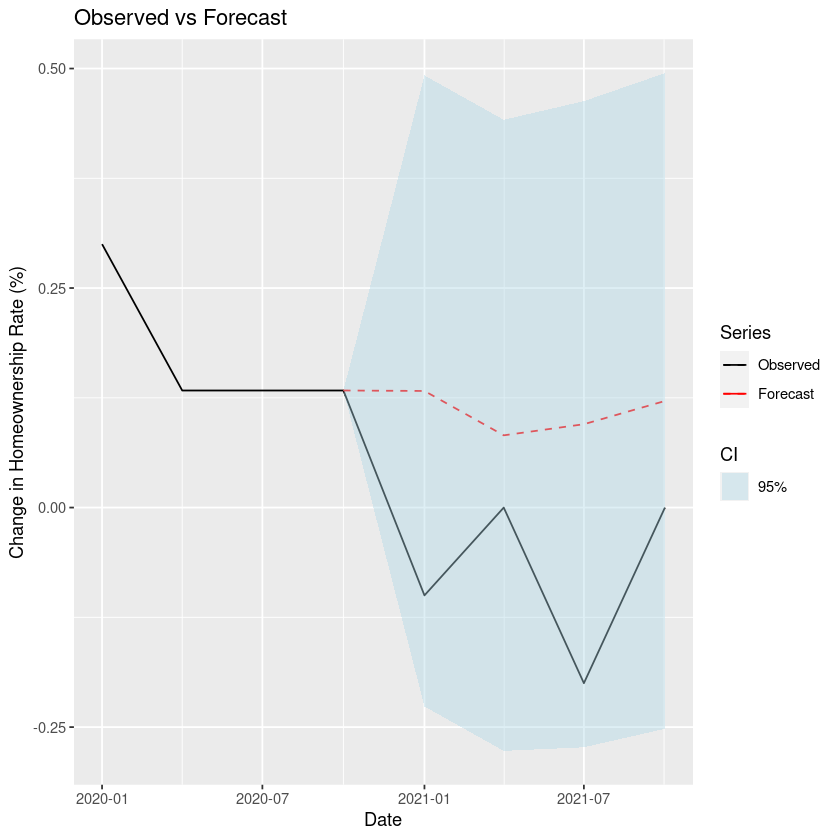

In [13]:
arima_fc <- forecast_arima(arima_model, homeownership_diff$Date, homeownership_diff$dValue, test_split, 95,
                    y_lab = "Change in Homeownership Rate (%)")
arima_fc$plot
fc_data <- tail(arima_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 1

PM =  4.004379

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.08426828,0.165922,0.1645173,NaN,Inf


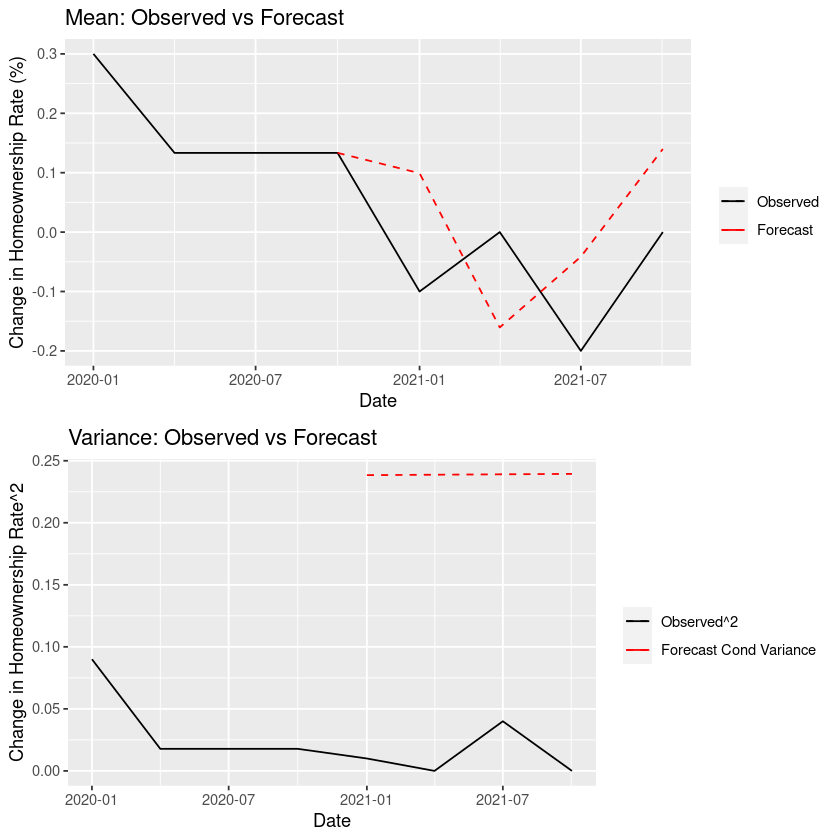

In [14]:
ugarch1_fc <- forecast_ugarchroll(ugarch_model1, homeownership_diff$Date, test$dValue, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
ugarch1_fc$plot
fc_data <- tail(ugarch1_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 2

PM =  3.939539

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1178569,0.1645732,0.1309458,NaN,Inf


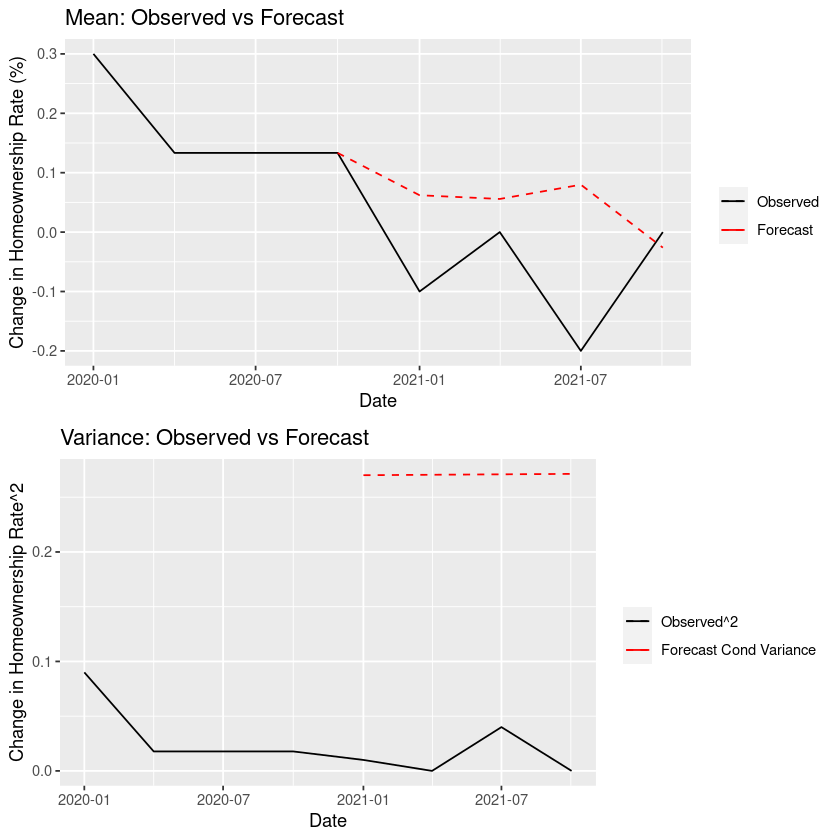

In [15]:
ugarch2_fc <- forecast_ugarchroll(ugarch_model2, homeownership_diff$Date, test$dValue, 4,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
ugarch2_fc$plot
fc_data <- tail(ugarch2_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

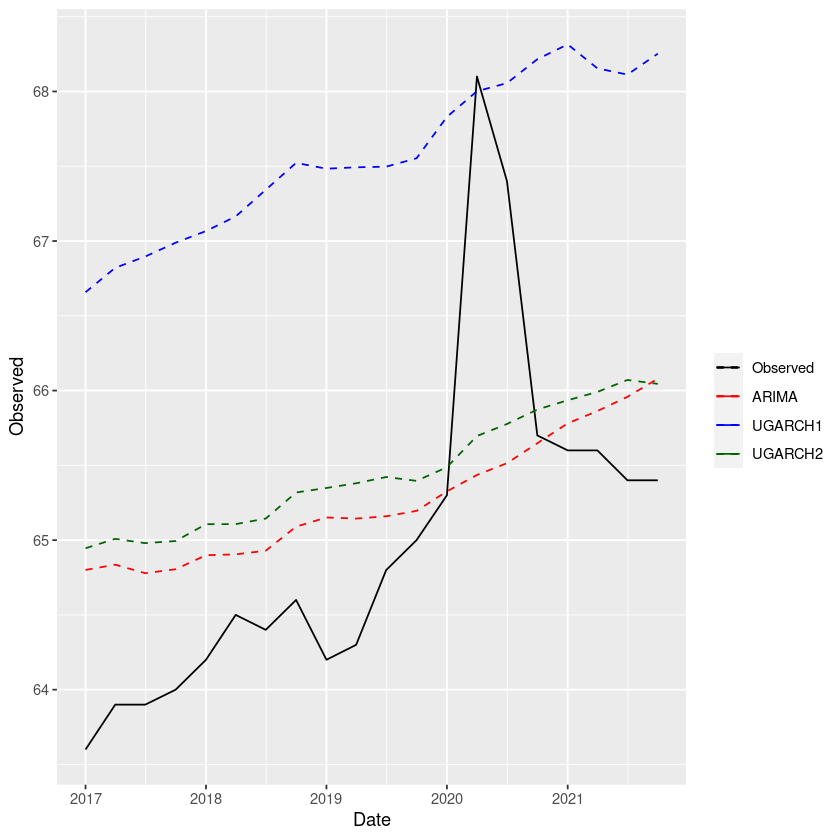

In [18]:
arima_recon <- diffinv(c(fitted(arima_model), tail(arima_fc$data$Forecast, test_split)),
                       xi = homeownership$Value[1])
ugarch1_recon <- diffinv(c(as.numeric(fitted(ugarch_model1)), tail(ugarch1_fc$data$Forecast, test_split)),
                        xi = homeownership$Value[1])
ugarch2_recon <- diffinv(c(as.numeric(fitted(ugarch_model2)), tail(ugarch2_fc$data$Forecast, test_split)),
                        xi = homeownership$Value[1])
combined_recon <- data.frame(Date = homeownership$Date,
                            Observed = homeownership$Value,
                            ARIMA = arima_recon,
                            UGARCH1 = ugarch1_recon,
                            UGARCH2 = ugarch2_recon)

combined_recon %>% tail(20) %>% ggplot() +
  geom_line(aes(x = Date, y = Observed, color = "Observed")) +
  geom_line(aes(x = Date, y = ARIMA, color = "ARIMA"), linetype = "dashed") +
  geom_line(aes(x = Date, y = UGARCH1, color = "UGARCH1"), linetype = "dashed") +
  geom_line(aes(x = Date, y = UGARCH2, color = "UGARCH2"), linetype = "dashed") +
  scale_color_manual("", values = c("Observed" = "black", "ARIMA" = "red",
                                    "UGARCH1" = "blue", "UGARCH2" = "darkgreen"))